# Step 1 :  Dataset Preparartion

## Importing libraries

In [ ]:
# Import libraries

import os
import cv2
import time
import random
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 0=ALL, 1=INFO, 2=WARNING, 3=ERROR

import joblib
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.python.platform import build_info
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Dense, ReLU, LeakyReLU, Softmax

In [ ]:
# print("cv2_version :",cv2.__version__)
# print("numpy_version :",np.__version__)
# print("tensorflow_version :",tf.__version__)
# print("cudnn_version",build_info.build_info['cudnn_version'])
# print("cuda_version",build_info.build_info['cuda_version'])

## Check for gpu or cpu  available

In [ ]:
# GPU is used for faster processing.
device =tf.config.list_physical_devices('GPU')
device

[]

## Load Dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
!ls

drive  sample_data


In [ ]:
# specify path for images
path='/content/drive/MyDrive/data/'

# path = './data2/'
# list down the folders
folders = os.listdir(path)
folders.sort()

print(f'Shots in a Dataset : {folders}')

Shots in a Dataset : ['cut-shot', 'drive', 'legglance-flick', 'pullshot', 'sweep']


In [ ]:
# create lists of cleaned images
images  = []
labels  = []

# for each folder
for folder in folders:
    # list down image names
    names=os.listdir(path+folder)
    # for each image
    for name in names:
        # read an image
        img=cv2.imread(path+folder+'/'+name)
        # append image to list
        images.append(img)
        # append folder name (type of shot) to list
        labels.append(folder)

# number of images
print(len(images))

5772


## Showing Some Images Form Dataset

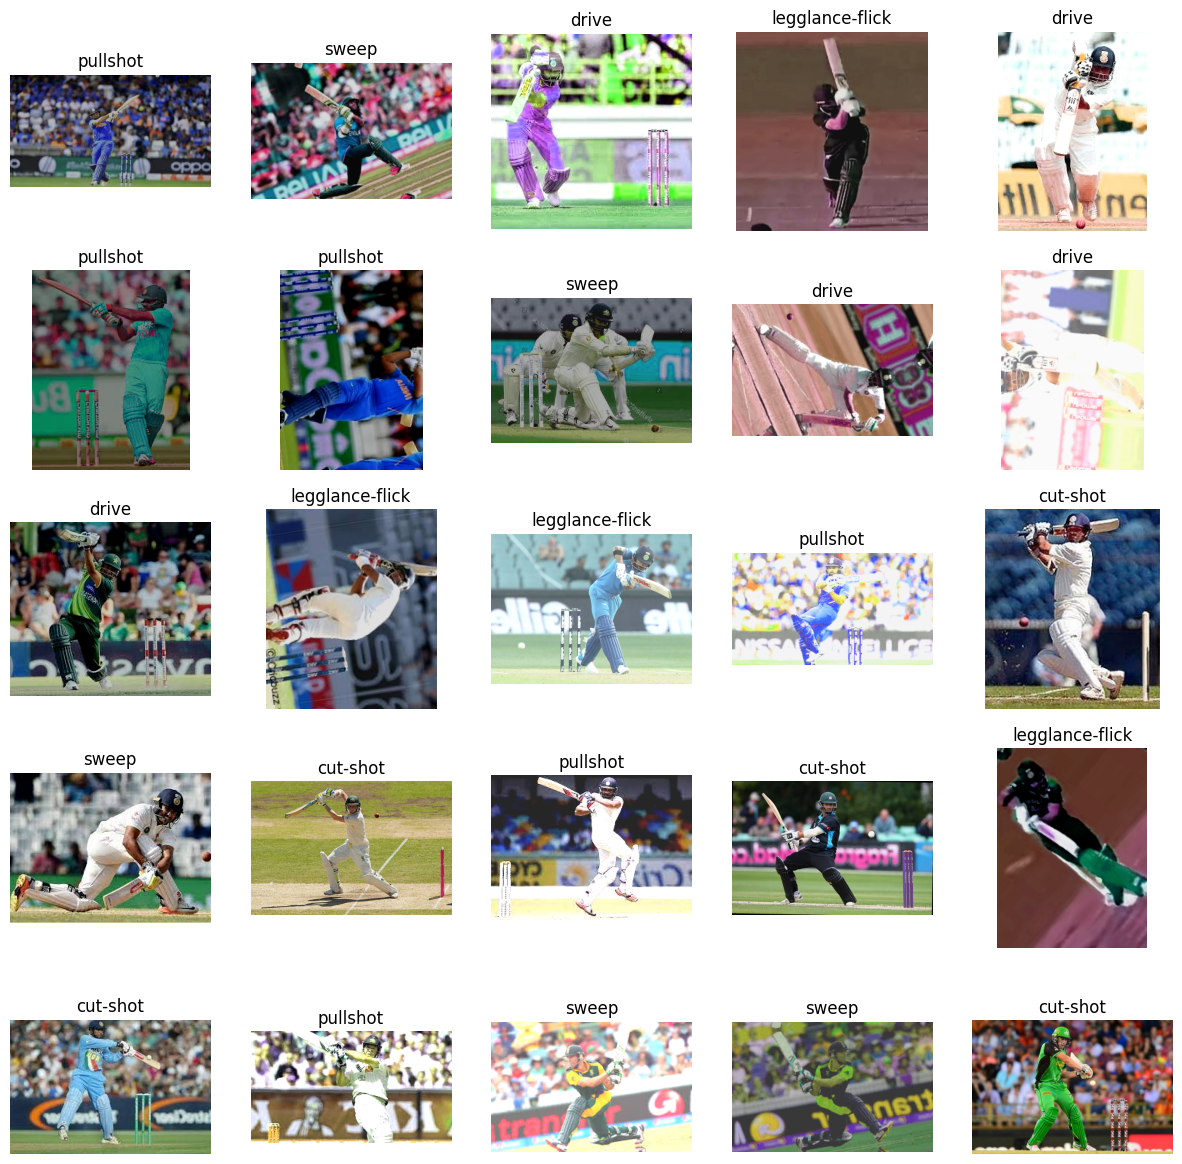

In [ ]:
# create subplots with 5 rows and 5 columns
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

# randomly sample indices
ind = random.sample(range(len(images)), 25)

for row in range(5):
  for col in range(5):
      img_idx = 5 * row + col  # Calculate the index for the ind list
      img = cv2.cvtColor(images[ ind[img_idx] ], cv2.COLOR_BGR2RGB)
      ax[row, col].imshow(img)
      # set title
      ax[row, col].set_title(labels[ ind[img_idx] ])
      # Turn off axis
      ax[row, col].axis('off')

# Step 2 : Data Augmentation

- To increase our training size so we’ll flip the images horizontally and this will help us with two things first of all the players can be both right-handed and left-handed so by flipping the images. It will make our model more generalized. It will also increase the number of images for training.

- The above Data is already augmented before going to train model. To Know how it is done, see the Data_Augmentation.ipynb notebook.



# Step 3 : KeyPoints Extraction using Yolo

In [ ]:
from ultralytics import YOLO

# Load a model
keypoint_model = YOLO('yolov8n-pose.pt')  # load a pretrained model

100%|██████████| 6.51M/6.51M [00:00<00:00, 55.2MB/s]


## Draw KeyPoints and Box on Some Images

In [ ]:
# Show keypoints on some images
fig, ax = plt.subplots(ncols=3,nrows=5 ,figsize=(30,30))

# randomly select images
for i,img in enumerate(random.sample(images,5)):

    # make predictions
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # prediction
    outputs = keypoint_model(img, conf=0.75, imgsz=(288,288), verbose=False)

    # find the objects in image
    num_instances = len(outputs[0])

    #print(num_instances)
    if(num_instances == 0):

        # If no instances were detected, display the original image
        img_with_bboxes = img_with_keypoints= img.copy()
        ax[i,2].imshow(img)
        ax[i,2].set_title("Failed to Detect")
        ax[i,2].axis("off")

    else:
        # Draw boxes
        img_with_bboxes = outputs[0].plot(boxes=True, kpt_radius=0, kpt_line=False, conf=True,labels=True)

        # Draw Keypoints
        img_with_keypoints = outputs[0].plot(boxes=True, line_width=2, kpt_radius=2,kpt_line=False, conf=True, labels=True)

        # Draw Keypoints with boxes
        img_with_keypoints_boxes =outputs[0].plot(boxes=True, line_width=2, kpt_radius=2,kpt_line=True, conf=True, labels=True)

        # display image
        ax[i,2].imshow(img_with_keypoints_boxes)
        ax[i,2].set_title("Keypoints with box")
        ax[i,2].axis("off")

    # display image
    ax[i,0].imshow(img_with_bboxes)
    ax[i,0].set_title("Bounding Boxes")
    ax[i,0].axis("off")

    ax[i,1].imshow(img_with_keypoints)
    ax[i,1].set_title("Keypoints")
    ax[i,1].axis("off")

Output hidden; open in https://colab.research.google.com to view.

## Extract KeyPoints For Each Image

In [ ]:
# function that extracts the keypoints for an image
def extract_keypoints(img):

  # make predictions
  outputs = keypoint_model.predict(img, conf= 0.75, imgsz=(288,288), verbose=False)
  keypoints = outputs[0].keypoints.xy.cpu().numpy()

  if(len(keypoints)>0):
    # fetch keypoints of a person with maximum confidence score
    kp = keypoints[0]
    # convert 2D array to 1D array
    kp = kp.flatten()
    # return keypoints
    return kp

In [ ]:
# Extract keypoints
start_time = time.time()
# create list
keypoints   = []

for i in tqdm(range(len(images))):
  # extract keypoints
  img = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  kp = extract_keypoints(img)
  # append keypoints
  keypoints.append(kp)

end_time = time.time()

# Calculate the training time
time_taken = end_time - start_time
tf.print(f"Time taken for video: {time_taken:.4f} seconds")

100%|██████████| 5772/5772 [03:37<00:00, 26.52it/s]

Time taken for video: 217.6550 seconds


## Remove Images on Which Keypoints are not Detetected

In [ ]:
# Finding the index of images on which keypoints is not detected.
indices = []
for i in range(len(keypoints)):
    if(len(keypoints[i])==0):
        indices.append(i)


# Delete that images and labels
for i in sorted(indices, reverse=True):
    del keypoints[i]
    del labels[i]
    del images[i]

# Remaining keypoints
print(len(keypoints))

3725


In [ ]:
keypoints = np.array([np.resize(k, (34,)) for k in keypoints])

# show some keypoints
keypoints

array([[     473.92,      127.44,      477.96, ...,      267.28,      456.82,      267.09],
       [     103.98,      27.069,      102.63, ...,      200.08,      63.132,      197.04],
       [     401.42,      102.67,      406.47, ...,      363.68,      451.93,      370.63],
       ...,
       [     113.23,      45.634,      118.93, ...,      195.48,      108.81,      208.33],
       [     37.239,      21.876,      40.283, ...,       162.1,      24.111,      160.74],
       [     37.508,      19.184,      40.567, ...,      165.59,      25.231,      164.37]], dtype=float32)

# Step 4 : Dataset Normalizaton and Label Encoding

## Normalize keypoints

In [ ]:
# define normalizer
scaler= StandardScaler()

# normalize keypoints
keypoints = scaler.fit_transform(keypoints)
keypoints = np.array(keypoints)

## Save Scaler Model For Use in Prediction

In [ ]:
# Specify the full path to the directory and the file name
directory_path = '/content/drive/MyDrive'
file_name = 'i_scaler.pkl'

# Save the model to the specified directory
joblib.dump(scaler, f'{directory_path}/{file_name}')

['/content/drive/MyDrive/i_scaler.pkl']

## Encoding Categorical Variable

In [ ]:
# label encoding
le = LabelEncoder()
y=le.fit_transform(labels)

## Mapping Between Label and Thier Corresponding Category

In [ ]:
#get original labels
original_labels = le.inverse_transform(y)

# Printing the label corresponds to which number
# for label, number in zip(original_labels, y):
#     print(f"{label} --> {number}")

showing result like this :     
{cut-shot --> 0, drive --> 1, legglance-flick --> 2, pullshot --> 3, sweep --> 4}

In [ ]:
# one-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes=5)

# Step 5 : Train And Test Split

In [ ]:
# Split into training (70%) and temporary set (30%) with stratification and shuffling
x_train, x_temp, y_train, y_temp = train_test_split(keypoints, y, test_size=0.3, stratify=y, shuffle=True, random_state=42)

# Split the temporary set into validation (20%) and test (10%) with stratification and shuffling
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=1/3, stratify=y_temp, shuffle=True, random_state=42)


## Shape of Training and Validation Set

In [ ]:
(x_train.shape, y_train.shape), (x_val.shape, y_val.shape), (x_test.shape, y_test.shape)

(((2607, 34), (2607, 5)), ((745, 34), (745, 5)), ((373, 34), (373, 5)))

# Step 6 : Model Architecture and Training

## Defining The Architecture of ANN Model

In [ ]:
# defining the model architecture
model = Sequential([
    Dense(128, input_shape=(34,), activation='relu'),
    Dense(256, activation='relu'),
    Dense(128),
    LeakyReLU(0.01),
    Dense(5, activation='softmax')
])

## Define Optimizer and Loss Function

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_226 (Dense)           (None, 128)               4480      
                                                                 
 dense_227 (Dense)           (None, 256)               33024     
                                                                 
 dense_228 (Dense)           (None, 128)               32896     
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_229 (Dense)           (None, 5)                 645       
                                                                 
Total params: 71045 (277.52 KB)
Trainable params: 71045 (277.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train a ANN Model

In [ ]:
# Model Training

start_time = time.time()

history = model.fit(x_train,y_train, epochs=25, batch_size=32, validation_data=(x_val,y_val),
                   callbacks = tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss',restore_best_weights=True))

end_time = time.time()

# Calculate the training time
time_taken = end_time - start_time
tf.print(f"Time taken for video: {time_taken:.4f} seconds")

Epoch 1/25
82/82 [==============================] - 1s 7ms/step - loss: 1.0336 - accuracy: 0.6068 - val_loss: 0.8138 - val_accuracy: 0.7141
Epoch 2/25
82/82 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.7714 - val_loss: 0.6661 - val_accuracy: 0.7597
Epoch 3/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5781 - accuracy: 0.7971 - val_loss: 0.6326 - val_accuracy: 0.7691
Epoch 4/25
82/82 [==============================] - 0s 3ms/step - loss: 0.5050 - accuracy: 0.8197 - val_loss: 0.5778 - val_accuracy: 0.8067
Epoch 5/25
82/82 [==============================] - 0s 2ms/step - loss: 0.4499 - accuracy: 0.8393 - val_loss: 0.5664 - val_accuracy: 0.8107
Epoch 6/25
82/82 [==============================] - 0s 2ms/step - loss: 0.4099 - accuracy: 0.8592 - val_loss: 0.5789 - val_accuracy: 0.8148
Epoch 7/25
82/82 [==============================] - 0s 3ms/step - loss: 0.3859 - accuracy: 0.8611 - val_loss: 0.5408 - val_accuracy: 0.8268
Epoch 8/25
82/82 [==

# Step 7 : Model Evaluation

## Monitoring Training and Validation Error

In [228]:
def plot_loss_acc_curve(history):

  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 12)

  # Plot loss
  ax1.set_title('Training and Validation Loss Curve')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'val')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  # Determine upper bound of y-axis
  max_loss = max(max(history.history['loss']) , max(history.history['val_loss']))
  ax1.set_ylim([0, (max_loss)])
  # ax1.set_ylim([0, 1])
  ax1.legend(['Train', 'Validation'])


  # Plot accuracy
  ax2.set_title('Training and Validation Accuracy Curve')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'val')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.legend(['Train', 'Validation'])

  plt.show()

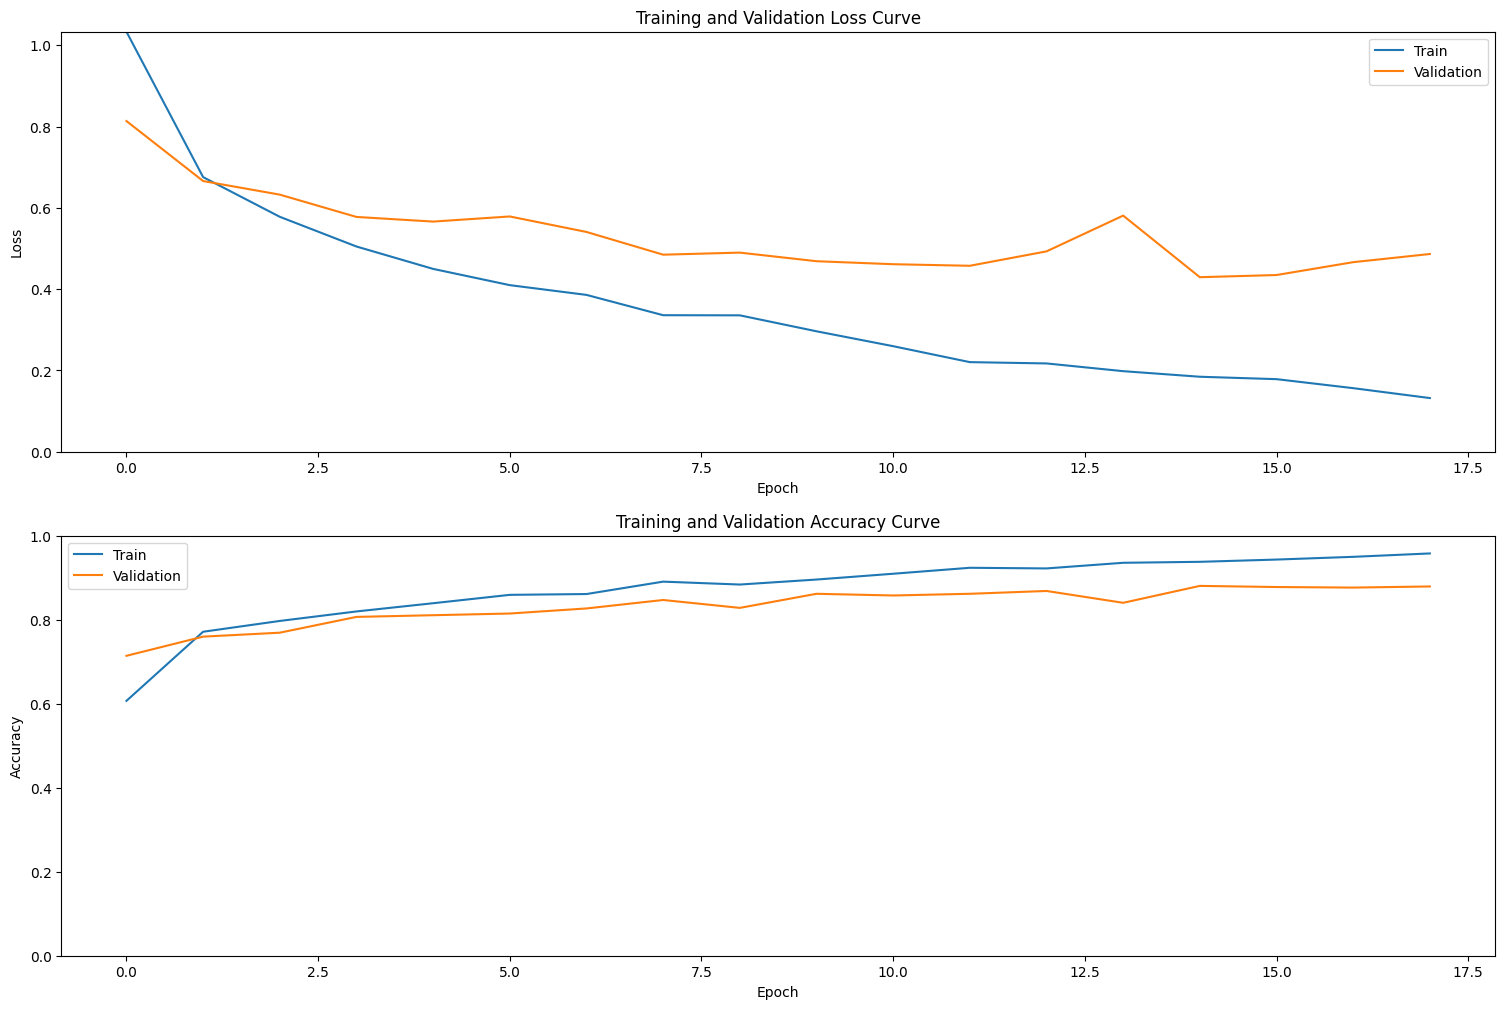

In [229]:
# plot curve
plot_loss_acc_curve(history)

## Performance Evaluation Metric

In [230]:
# Evaluate the model
def evaluate_model(x, y, ds_type):
    loss, accuracy = model.evaluate(x,y,verbose=0)
    tf.print(f'{ds_type} set Accuracy: {accuracy * 100:.2f}%')

In [231]:
# Evaluate on Train set
evaluate_model(x_train, y_train, ds_type="Training")

# Evaluate on Train set
evaluate_model(x_val, y_val, ds_type="Validation")

# Evaluate on Train set
evaluate_model(x_test, y_test, ds_type="Test")

Training set Accuracy: 95.24%
Validation set Accuracy: 88.05%
Test set Accuracy: 89.01%


## Classification Report

In [232]:
# Classsifiaction report
def precision_recall_f1_score(x, y , ds_type):
    actual= np.argmax(y, axis=1)

    predicted = model.predict(x ,verbose=0)
    predicted = np.argmax(predicted, axis=1)

    # Generate the classification report
    labels = ['cut-shot', 'drive', 'legglance-flick', 'pullshot', 'sweep']
    report = classification_report(actual, predicted, target_names=labels)
    # report = classification_report(actual, predicted)
    tf.print(f'{ds_type} set Classification report: \n {report}')

In [233]:
# Plot Training report
precision_recall_f1_score(x_train, y_train, ds_type="Training")

# Plot Validation report
precision_recall_f1_score(x_val,y_val, ds_type="Validation")

# Plot Test report
precision_recall_f1_score(x_test,y_test, ds_type="Test")

Training set Classification report: 
                  precision    recall  f1-score   support

       cut-shot       0.98      0.92      0.95       668
          drive       0.91      0.95      0.93       516
legglance-flick       0.93      0.97      0.95       527
       pullshot       0.96      0.94      0.95       439
          sweep       0.99      0.99      0.99       457

       accuracy                           0.95      2607
      macro avg       0.95      0.95      0.95      2607
   weighted avg       0.95      0.95      0.95      2607

Validation set Classification report: 
                  precision    recall  f1-score   support

       cut-shot       0.92      0.81      0.86       190
          drive       0.81      0.84      0.82       148
legglance-flick       0.83      0.91      0.87       151
       pullshot       0.91      0.93      0.92       125
          sweep       0.94      0.95      0.94       131

       accuracy                           0.88       745
     

## Plot Confusion Matrix

In [234]:
# Confusion matrix
def plot_confusion_matrix(x, y, ds_type):
  actual= np.argmax(y, axis=1)

  predicted = model.predict(x,verbose=0)
  predicted = np.argmax(predicted, axis=1)
  labels = ['cut-shot', 'drive', 'legglance-flick', 'pullshot', 'sweep']
  cm = tf.math.confusion_matrix(actual, predicted)
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted labels')
  plt.ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  plt.title('Confusion matrix of action recognition for ' + ds_type+' set')
  plt.show()

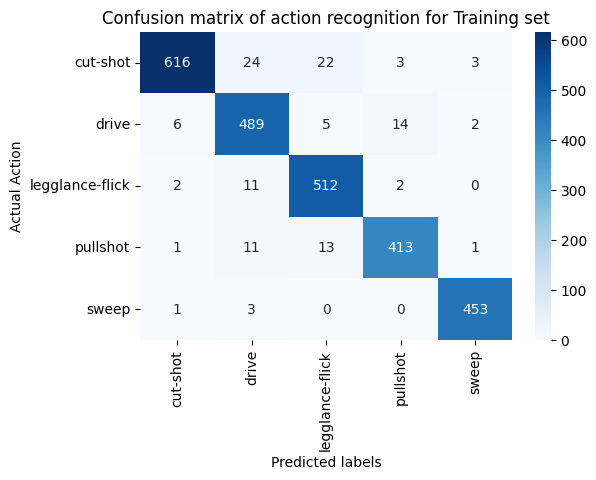

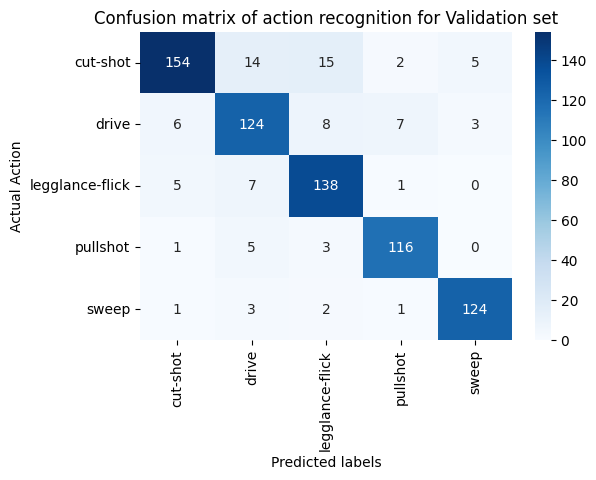

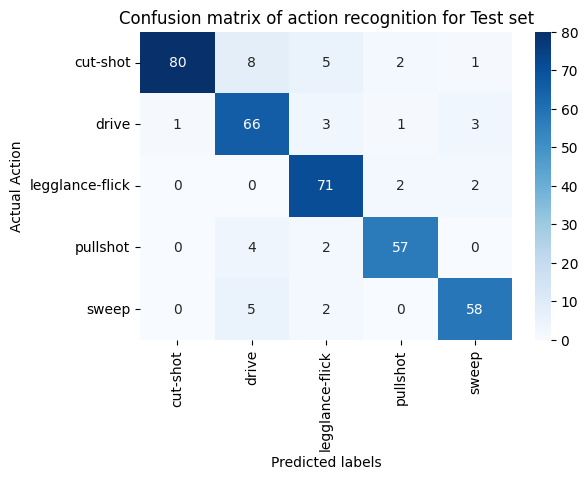

In [235]:
# confusion matrix for Training set
plot_confusion_matrix(x_train, y_train, ds_type='Training')

# confusion matrix for Validation set
plot_confusion_matrix(x_val, y_val, ds_type='Validation')

# confusion matrix for Test set
plot_confusion_matrix(x_test, y_test, ds_type='Test')

## Save Model

In [236]:
#save model
model.save('/content/drive/MyDrive/i_model.keras')
tf.print('Model Saved!')

Model Saved!


In [237]:
# load model
#model=load_model('videoModel2.keras')
# tf.print('Model Loaded!')
#model.summary()

# Step 8 : Prediction on new Data

## Create a Function for Prediction

In [238]:
def prediction(image):

    kpp= extract_keypoints(image)
    kpp = scaler.transform(kpp.reshape(1, -1))
    kpp = np.array(kpp)

    x_t = kpp

    pred = model.predict(x_t,verbose=0)
    pred = np.argmax(pred, axis=1)

    shot_types = ['cut-shot', 'drive', 'legglance-flick', 'pullshot', 'sweep']

    predicted_shot = shot_types[pred[0]]

    return predicted_shot

## Plot Some Prediction

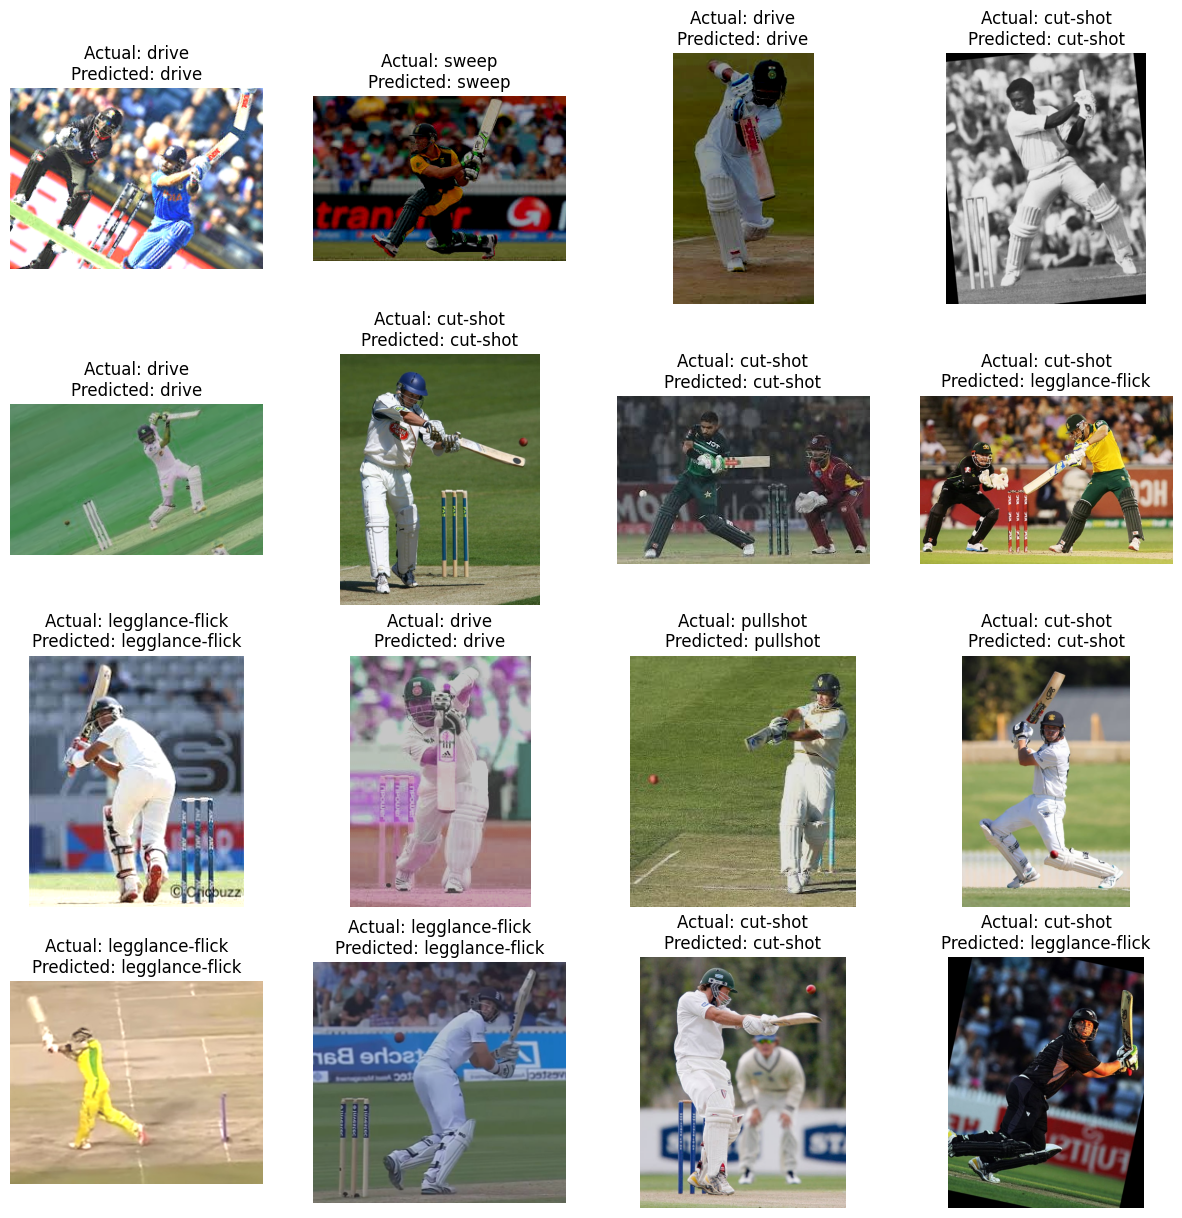

In [239]:
# create subplots with 4 rows and 4 columns
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15,15))

# randomly sample indices
ind = random.sample(range(len(images)), 16)

for row in range(4):
  for col in range(4):
      img_idx = 4 * row + col  # Calculate the index for the ind list
      img = cv2.cvtColor(images[ ind[img_idx] ], cv2.COLOR_BGR2RGB)
      actual_label = labels[ ind[img_idx] ]
      predicted_label = prediction(img)
      # display image
      ax[row, col].imshow(img)
      # set title
      ax[row, col].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
      # Turn off axis
      ax[row, col].axis('off')